In [10]:
import ypred_module as ypm
import train_conditional as train
import tools_conditional as tools

import numpy as np
import time

import matplotlib.pyplot as plt

# Training Environment


An environment to train model with different number of nodes in hidden layers, different number of basis functions, or different metrics for training and visualize results. 

------

### Load in Data
First, load in the data. Files for training, testing, and validation are stored in <code>./data/</code>: There are 6 training, 2 validation, and 3 testing files, with the conditional distributions for 256 example rate parameters $\theta = \{ b,\beta,\gamma \}$, corresponding to 31 to several hundred conditional examples: 
1. <code>256_train_0.npy, 256_train_1.npy, 256_train_2.npy, 256_train_3.npy, 256_train_4.npy, 256_train_5.npy</code> 
2. <code>256_valid_0.npy, 256_valid_1.npy</code> 
3. <code>256_test_0.npy, 256_test_1.npy, 256_test_2.npy</code> 

There are also 3 files containing full Probability Mass Function (PMF) arrays (instead of conditional vectors) for the testing rate parameters:
1. <code>256_test_full_0.npy, 256_test_full_1.npy, 256_test_full_2.npy</code> 


In [11]:
data_path = './data/'
training_set = train.load_data(number_of_files = 2 ,file_path = data_path ,name = '256_train')
validation_set = train.load_data(number_of_files = 2 ,file_path = data_path ,name = '256_valid')
testing_set = train.load_data(number_of_files = 2 ,file_path = data_path ,name = '256_test')

### Specify model and training configurations
Next, specify the model and training configurations. 

The model has two layers with variable number of nodes in each layer.


The model_config specifies:
* <code>input_dim</code> : the input size (parameter vector length -- 7 for conditional training)
* <code>h1_dim</code>: the dimension of the first hidden layer (which is used to predict the hyperparameter h)
* <code>h2_dim</code> : the dimension of the second hidden layer
* <code>npdf</code> : the number of kernel functions (and the size of output weight vector w)


The train_config specifies:
* <code>num_epochs</code>: the number of epochs to loop over data
* <code>lr</code> : learning rate for optimizer
* <code>weight_decay</code> : optional weight decay, can set to 0
* <code>metric</code> : metric to use as loss with options:
    * **'kld' Kullback-Leibler Divergence** (suggested)
    * 'kld_normalized' Kullback-Leibler Divergence 
    * 'mse' Mean Squared Error
    * 'se' Total Squared Error

In [308]:
model_config = {
    'input_dim' : 7,
    'npdf' : 5,
    'h1_dim' : 256,
    'h2_dim' : 256,
}

train_config = {
    'num_epochs' : 5,
    'lr' : 1e-3,
    'weight_decay' : 0,
    'batchsize' : 64,
    'metric' : 'kld'
}

### Train!

And now, train your model! 

Train.train returns model, trianing loss over epochs, and validation loss over epochs. 


Can subset training data for faster training: training_set[start:stop], validation_set[start:stop].

In [309]:
t1 = time.time()

model, train_metvals, valid_metvals = train.train(training_set[0:10000],validation_set[0:1000],model_config,train_config)

t2 = time.time()
t = t2-t1
print(f'Training time was {t:4f} seconds, {t/60:4f} minutes.')



Epoch Number: 1
Train metric: 0.08446674048900604
Valid metric: 0.055555143020566904
Epoch Number: 2
Train metric: 0.051805753260850906
Valid metric: 0.052027485500933834
Epoch Number: 3
Train metric: 0.0492599792778492
Valid metric: 0.05104462106726714
Epoch Number: 4
Train metric: 0.048194095492362976
Valid metric: 0.04986567505227867
Epoch Number: 5
Train metric: 0.04740316793322563
Valid metric: 0.04853475920390338
Training time was 167.829928 seconds, 2.797165 minutes.


Save the model and metadata, if desired! 

In [ ]:
# save_path = './models/'
# tools.save_model(model,model_config,train_config,epoch_metvals,valid_metvals,t,path,name)
# tools.save_model(model,model_config,train_config,epoch_metvals,valid_metvals,t,save_path,name='TEST_1')

------
# Assessment and visualization 

First, compare training loss for training and validation data. 

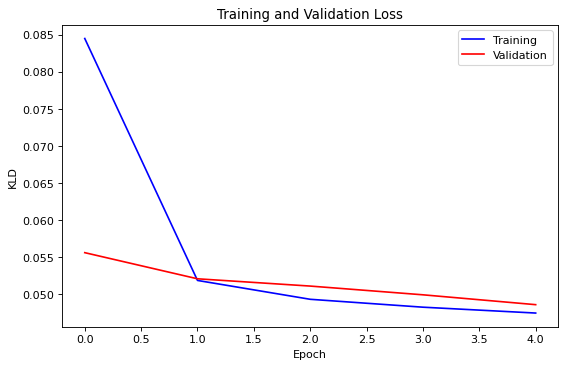

In [311]:
tools.plot_loss(train_metvals,valid_metvals,metric='KLD')

### Test Metrics

Calculate metrics for test data: KLD for conditional testing examples. Plot histograms, CDF. 

If no model is given, all is calculated with the final model stored in <code> /models/best_model_MODEL/ </code>.

In [312]:
# test_klds = tools.get_conditional_metrics(testing_set[0:10],metric='KLD',model=model)

test_klds = tools.get_conditional_metrics(testing_set[0:10],metric='KLD',model=ypm.model)

/home/mcarilli/CME/git/CME_approximations/Paper/ypred_module.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index = torch.tensor(m_range+1,dtype=torch.long)


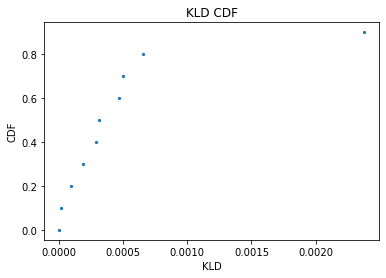

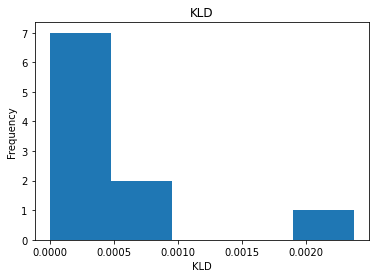

In [313]:
tools.plot_CDF(test_klds)
tools.plot_histogram(test_klds,bins=5)

Plot quantiles of calculated test metrics -- which parameter vectors resulted in higher KLD values. 

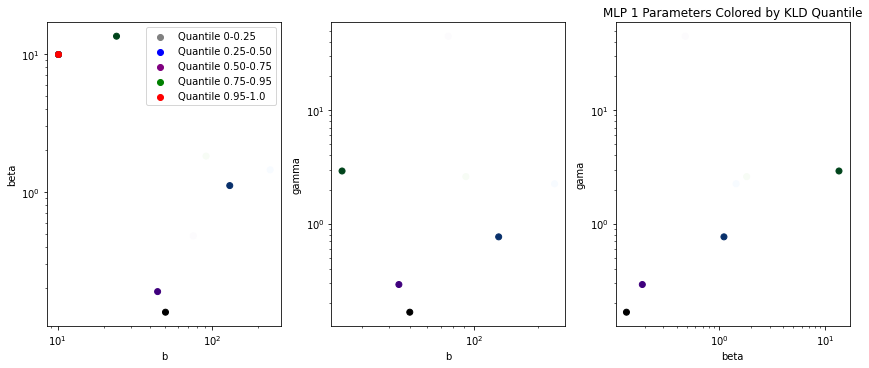

In [314]:
tools.plot_param_quantiles(test_klds,testing_set[0:10])

### Look at some full PMFs! 


First, load in the testing data files in which the arrays of PMFs are stored. 


In [7]:
full_test_set = train.load_data(number_of_files = 1 ,file_path = data_path ,name = '256_test_full')

You can either give the function <code>plot_pmf</code> the parameter rate vector and the true stored PMF, or simply a parameter rate vector (it will calculate the true PMF rather than accessing the stored PMF).
 
If no model is passed, the approximation is again generated with the final model stored in <code> /models/best_model_MODEL/ </code>.

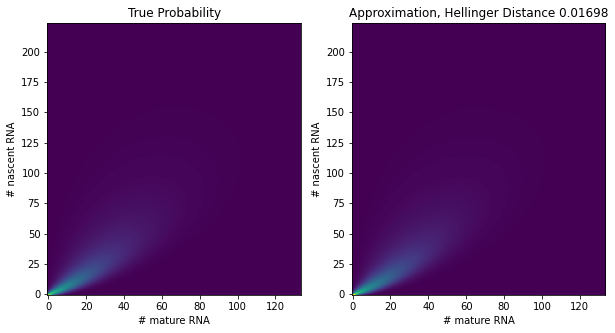

In [12]:
i = 96


p,y = full_test_set[i][0],full_test_set[i][1]

#tools.plot_pmf(p,true_pmf=y,model=model)
tools.plot_pmf(p,true_pmf=y)

Or, generate approximation and truth for any rate parameter vector.

The p vector must be of the form the log10 of average burst size b, rate of splicing Beta, and rate of degradation gamma, where Beta and gamma are not absolute but relative the rate of transcriptional initiation. 

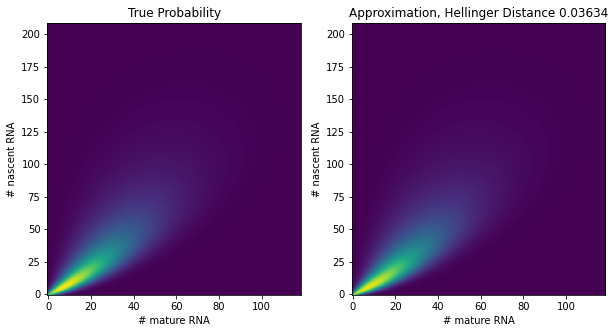

In [13]:
# try any p! 

p_new = np.log10(np.array([30,0.6,0.9]))

tools.plot_pmf(p_new)